發現：
- 7 day is a small period that largely formed from close or low sale at weekend , 14 day is another period that promo kicks in.
- promo period is not regular,有時候連兩個禮拜promo.
- Some stores have long state of close. If reopen then sale surges. [see](# reopen)
- Stores that open but 0 sales are happened 2-3 days before reopen. (只根據兩個例子) [see](# open-but-0-sales)

問題：
- Some stores closes over the last day of train. 感謝Erica提供.
    - 永久停業？ 還是暫停營業？
    - 如果關閉那就沒預測需求，host會故意放上來？

In [65]:
%load_ext autoreload
%aimport utility
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



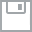
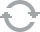
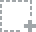
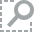
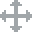
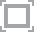
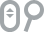
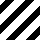
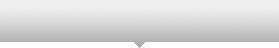
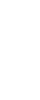
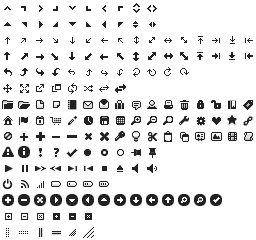
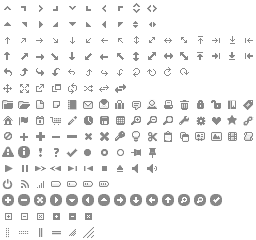
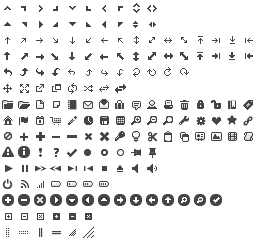
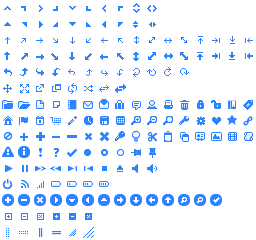
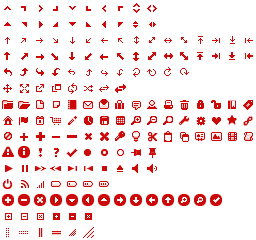
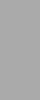
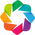
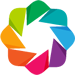

In [66]:
import pandas as pd
pd.options.display.max_rows=10
import numpy as np

from bokeh.io import output_notebook, show 
from bokeh.plotting import figure
from  bokeh.mpl import to_bokeh
output_notebook()

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
sb.set_style("whitegrid")
plt.rcParams['figure.figsize']=(6,4)
sb.set_palette('colorblind')

In [10]:
train=utility.get_train()

/Users/apple/miniconda3/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [7]:
from ipywidgets import interact
def plot_timeseries(store_n,df=train,time_range=['2014-01-01','2014-12-31'], title=None):
    df = df[df.Store==store_n]
    df=df[df.Date.between(*time_range)]
    
    #preprocess
    state_holiday=df.Date[(df.StateHoliday!='0')&(df.StateHoliday!='nan')]
    school_holiday=df.Date[df.SchoolHoliday==1]
    weekend=df.Date[(df.Date.dt.weekday==5) | (df.Date.dt.weekday==6)]
    promo_ranges = []
    import itertools
    for k, g in itertools.groupby(df[['Date','Promo']].values,lambda x: x[1]): #group by Promo
        if k==1:
            g=list(map(lambda x:x[0],g))
            promo_ranges.append((g[0],g[-1]))

    #---------------------- plot -----------------------------
    from bokeh.models import HoverTool,BoxAnnotation,ColumnDataSource
    TOOLS = 'wheel_zoom,pan,resize,reset'
    p = figure(x_axis_type="datetime",plot_width=1000,plot_height=400,tools=TOOLS)


    source = ColumnDataSource(data=df)
    p.line('Date', 'Sales' , source=source)
    p.circle('Date', 'Sales', size=3,source=source)

    #state holiday
    p.ray(x=state_holiday, y=0, length=0, angle=np.pi/2, color='red',line_dash=[5,5])
    p.ray(x=state_holiday, y=0, length=0, angle=-np.pi/2, color='red',line_dash=[5,5])
    #schoold holiday
    p.ray(x=school_holiday, y=0, length=0, angle=np.pi/2, color='green',line_dash=[1,8])
    p.ray(x=school_holiday, y=0, length=0, angle=-np.pi/2, color='green',line_dash=[1,8])
    #weekend??
    p.ray(x=weekend, y=0, length=0, angle=np.pi/2, color='yellow',line_dash=[2,5] )
    p.ray(x=weekend, y=0, length=0, angle=-np.pi/2, color='yellow',line_dash=[2,5])

    #promo  , the band is inclusive
    boxs=[BoxAnnotation(plot=p, left=l.value/1e6, right=r.value/1e6, fill_alpha=0.1, fill_color='green') for l,r in promo_ranges]
    p.renderers.extend(boxs)


    p.xaxis.axis_label = "Date"
    p.yaxis.axis_label = "Sale"
    if title : p.title = title 
    else: p.title='store'+ str(store_n)
    hover = HoverTool()
    hover.tooltips = {"value": "$y","time": '$x'}
    p.add_tools(hover)

    show(p) # show the results 

    #for interact
    def update(window_size='1',weekend=False):
        ma=pd.rolling_apply(df.Sales,int(window_size),np.average,center=True,min_periods=None,freq=None)
        source.data['Sales']=ma
        source.push_notebook()

    return update

# median 

In [8]:
sr=train.groupby('Date')['Sales'].agg(np.median)
df=train[train.Store==1]
df=df.merge(pd.DataFrame(sr), left_on = 'Date',right_index=True,how='right',suffixes=('_',''))
cb=plot_timeseries(1,df=df,title='median')

In [9]:
interact(cb)

<function __main__.plot_timeseries.<locals>.update>

# store1081 is "always open"

In [10]:
cb=plot_timeseries(1081)

In [11]:
interact(cb)

<function __main__.plot_timeseries.<locals>.update>

比較發現 Script討論區 的位移錯誤，i.e.沒有center

In [12]:
cb=plot_timeseries(590)

# reopen
stores that reopen and sale surges

In [13]:
cb=plot_timeseries(972)

# open but 0 sales
可以發現都是reopen前兩三天出現

In [14]:
#open but 0 sales at 2014-06-04 ~ 2014-06-05
cb=plot_timeseries(1017,time_range= ['2014-05-01' ,'2014-07-01']) 

In [15]:
#2014-09-02 ~ 04
cb=plot_timeseries(28,time_range=['2014-08-01','2014-10-01'])

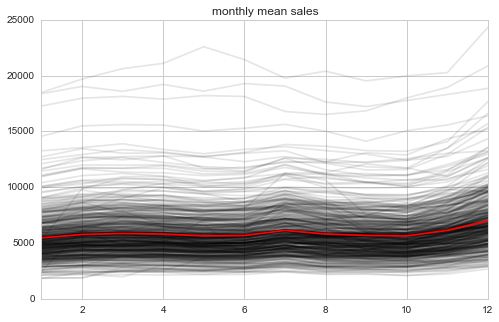

In [83]:
df=utility.sample_df(train,time_range=('2013-01-01','2014-12-31'),store_frac=0.5,reindex=True,use_days_from=False)
wide_df=df.pivot('Date','Store','Sales').asfreq('1D')
monthly_ag=wide_df.groupby(wide_df.index.month).agg(np.mean)
f,ax=plt.subplots(figsize=(8,5))
monthly_ag.plot(legend=False,alpha=.1,color='k',ax=ax)
# monthly_ag.T.boxplot()
monthly_ag.apply(np.mean,axis=1).plot(alpha=1,color='r',ax=ax)
ax.set_title('monthly mean sales')

In [ ]:
df.plot(rot=)

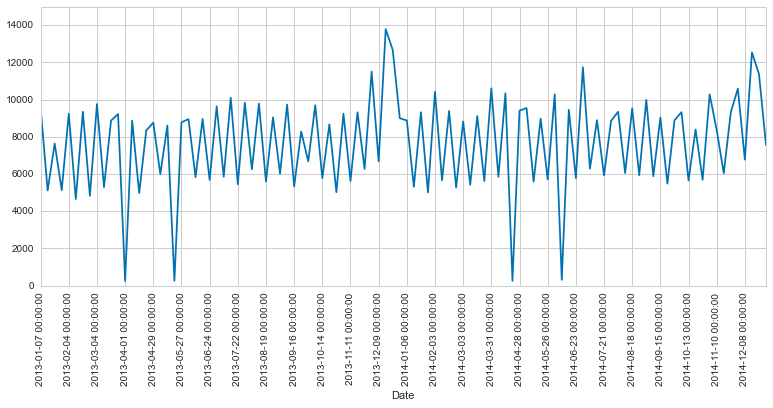

In [160]:
df=utility.sample_df(train,time_range=('2013-01-01','2014-12-31'),store_frac=0.5,reindex=True,use_days_from=False)
df=df.pivot('Date','Store','Sales').asfreq('1D').apply(np.mean,axis=1)

from IPython.html.widgets import interact
def dayly(day=1, window=1):
    _df=df[(df.index.weekday+1)==day]
    _df=pd.rolling_mean(_df, window=window)
    ax=_df.plot(ylim=(0,1.5e4),rot=90)
    ax.figure.set_size_inches(13,5)
    import matplotlib.dates as dates
    ax.xaxis.set_major_locator(dates.DayLocator())
    n=4
    ticklabels = [t for t in _df.index.to_pydatetime()]
    ax.xaxis.set_ticks(ax.xaxis.get_ticklocs()[::n])
    ax.xaxis.set_ticklabels(ticklabels[::n])

cc = interact(dayly, day=(1, 7, 1), window=(1,30,1))

# does Store Type get different time-series?

In [11]:
store=utility.get_store()
full_df=train.merge(store,on='Store',how='inner')
sample_df=utility.sample_df(full_df,store_frac=0.5,reindex=True,use_days_from=True)
# df=df[df.Open==1]

In [10]:
full_df[full_df.Date=='2014-01-01'].StoreType.value_counts()

a    602
d    348
c    148
b     17
dtype: int64

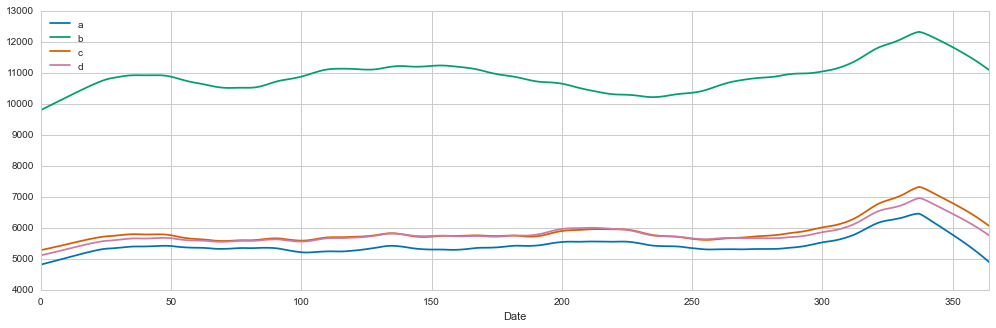

In [62]:
import statsmodels.api as sm
df=sample_df
f,ax=plt.subplots(1)
# ax.set_ylim(0,3e4)
ax.figure.set_size_inches(17,5)
for k,g in df.groupby('StoreType'):
    smooth=sm.nonparametric.lowess(g['Sales'],g['Date'],
        frac=0.15, it=3, delta=0.0)
    smooth_df=pd.DataFrame(smooth,columns=['Date','Sales'])
    ax=smooth_df.plot(x='Date',y='Sales',label=k,ax=ax)
# show(to_bokeh())

In [14]:
full_df[full_df.Date=='2014-01-01'].Assortment.value_counts()

a    593
c    513
b      9
dtype: int64

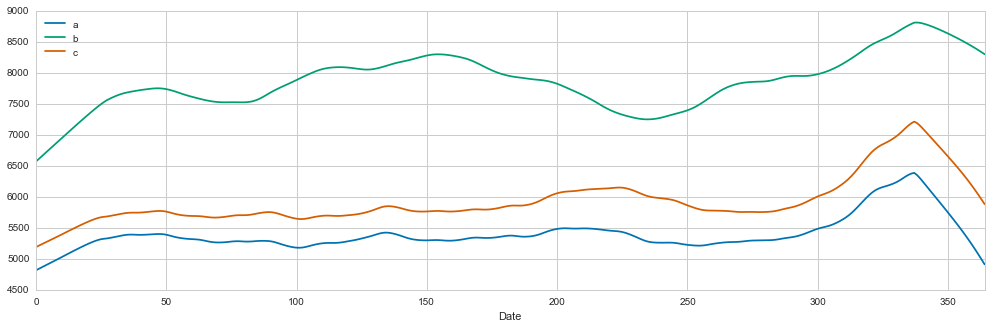

In [61]:
import statsmodels.api as sm
df=sample_df
f,ax=plt.subplots(1)
ax.figure.set_size_inches(17,5)
for k,g in df.groupby('Assortment'):
    smooth=sm.nonparametric.lowess(g['Sales'],g['Date'],
        frac=0.15, it=3, delta=0.0)
    smooth_df=pd.DataFrame(smooth,columns=['Date','Sales'])
    ax=smooth_df.plot(x='Date',y='Sales',label=k,ax=ax)
# show(to_bokeh())

In [15]:
full_df[full_df.Date=='2014-01-01'].PromoInterval.value_counts()

nan                 544
Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
dtype: int64

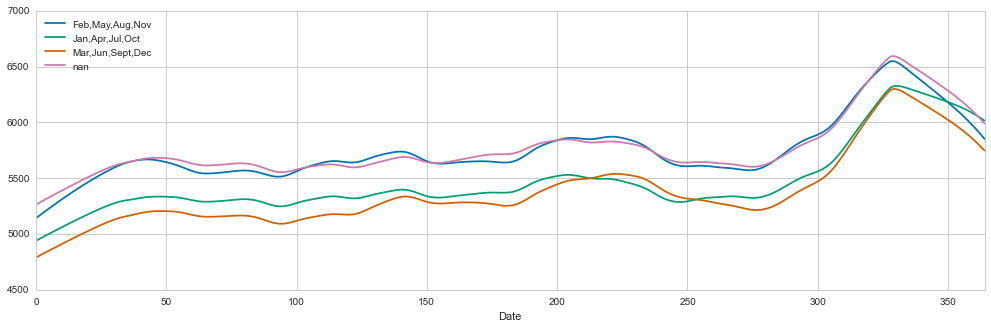

In [63]:
import statsmodels.api as sm
df=sample_df
f,ax=plt.subplots(1)
ax.figure.set_size_inches(17,5)
df.PromoInterval=df.PromoInterval.astype(np.str)
for k,g in df.groupby('PromoInterval'):
    smooth=sm.nonparametric.lowess(g['Sales'],g['Date'],
        frac=0.2, it=3, delta=0.0)
    smooth_df=pd.DataFrame(smooth,columns=['Date','Sales'])
    ax=smooth_df.plot(x='Date',y='Sales',label=k,ax=ax)
# show(to_bokeh())

In [67]:
ax=sb.tsplot(data=sample_df,time='Date',unit='Store',value='Sales',condition='StoreType',
             err_style='ci_band',n_boot=1000,estimator=np.median,ci=68
            ) # err_style={ci_band, ci_bars, boot_traces, boot_kde, unit_traces, unit_points}
ax.figure.set_size_inches(13,5)
ax.legend('upper center')
show(to_bokeh())

/Users/apple/miniconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


/Users/apple/miniconda3/lib/python3.4/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/apple/miniconda3/lib/python3.4/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/apple/miniconda3/lib/python3.4/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/apple/miniconda3/lib/python3.4/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


(-10000.0, 20000.0)

/Users/apple/miniconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


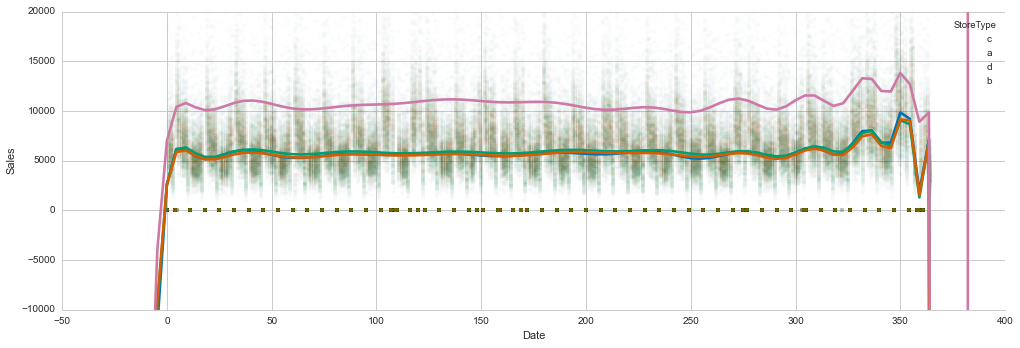

In [24]:
df=sample_df
_df=df.copy()
# _df.Sales=_df.Sales/3e4
ax=sb.lmplot('Date','Sales',hue='StoreType',data=_df,scatter=False,scatter_kws={'alpha':0.01},
             order=120,ci=None,legend_out=False,size=5,aspect=3)
ax.fig.set_size_inches(14,5)
ax.fig.axes[0].set_ylim(-1e4,2e4)
# show(to_bokeh())

In [25]:
# ax=sb.tsplot(data=df,time='Date',unit='Store',value='Sales',
#              err_style='unit_traces',n_boot=1,estimator=np.median,
#             ) # err_style={ci_band, ci_bars, boot_traces, boot_kde, unit_traces, unit_points}
# ax.figure.set_size_inches(13,5)
# show(to_bokeh())

In [26]:
# f,ax1=plt.subplots()
# ax1=pd.tools.plotting.autocorrelation_plot(train[train.Store==1].Sales,ax=ax1)
# f.set_figwidth(15)
# ax1.set_xlim(0,40)
# # show(to_bokeh(f))

# ============

In [34]:
sales_avg=train[train.Open==1].groupby('Store')['Sales'].agg(np.mean)
sales_avg.name='meanSales'

In [37]:
df=store.merge(pd.DataFrame(sales_avg,),left_on='Store',right_index=True,)

/Users/apple/miniconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


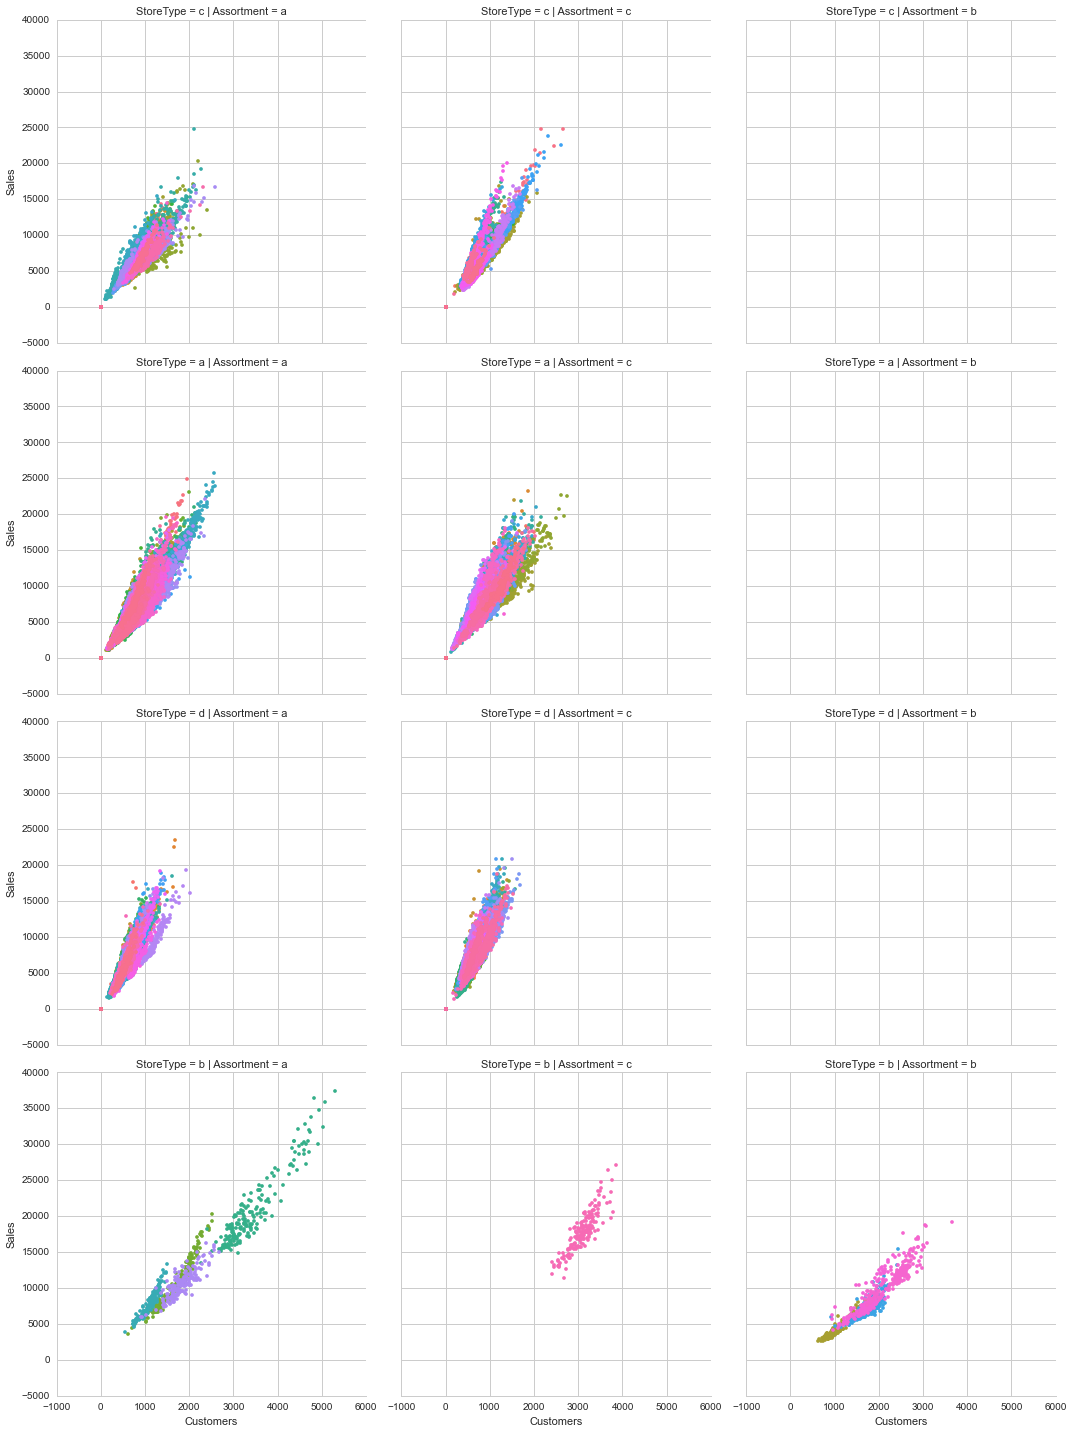

In [67]:
kws = dict(s=10, linewidth=.5, edgecolor="w")
g = sb.FacetGrid(sample_df.sample(frac=0.5), row="StoreType",col='Assortment',size=5,hue='Store',)
g.map(plt.scatter, "Customers", "Sales",**kws)

In [38]:
df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'meanSales'],
      dtype='object')

In [70]:
# import seaborn as sb
# x=np.array(range(30))
# z=np.hstack([[10]*10,[15]*10,[20]*10])
# y=-x+z*3+np.random.random(30)*5
# df=pd.DataFrame({'x':x,'y':y,'z':z})
# sb.regplot("x", "y", data=df,
#            x_partial=df["z"],
#            y_partial=df["z"],
#           )
# # iris = sb.load_dataset("iris")
# # sb.regplot("sepal_length", "sepal_width", data=iris,
# #             x_partial=iris["petal_length"]
# #           )